In [246]:
import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
import sys
import os

sys.path.append("../../")
#my modules
from ArchPy.base import *
from ArchPy.tpgs import *


In [ ]:
#grid
sx = 1.5
sy = 1.5
sz = .15
x0 = 0
y0 = 0
z0 = -15
nx = 140
ny = 70
nz = 70
x1 = x0 + nx*sx
y1 = y0 + ny*sy
z1 = z0 + nz

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

domain = np.ones([ny,nx],dtype=bool)
domain[: 5]= 0
plt.imshow(domain)

In [ ]:
## create pile

P1 = Pile(name = "P1",seed=1)

#units covmodel
covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodelD1 = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[30,30]})])
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[40,40]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[50,50]})])

## facies covmodel
covmodel_SIS_C = gcm.CovModel3D(elem=[("exponential", {"w":.21,"r":[50, 50, 10]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B1 = gcm.CovModel3D(elem=[("exponential", {"w":.16,"r":[50, 50, 2]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B2 = gcm.CovModel3D(elem=[("exponential", {"w":.24,"r":[100, 100, 3]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B3 = gcm.CovModel3D(elem=[("exponential", {"w":.19,"r":[50, 50, 2]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B4 = gcm.CovModel3D(elem=[("exponential", {"w":.13,"r":[100, 100, 4]})], alpha=0, name="vario_SIS") # input variogram

lst_covmodelC=[covmodel_SIS_C] # list of covmodels to pass at the function
lst_covmodelB=[covmodel_SIS_B1, covmodel_SIS_B2, covmodel_SIS_B3, covmodel_SIS_B4] # list of covmodels to pass


#create Lithologies 
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD}
dic_f_D = {"f_method":"homogenous"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC, "mean":-6.5}
dic_f_C = {"f_method" : "SIS","neig" : 10, "f_covmodel":lst_covmodelC, "probability":[0.3, 0.7]}
C = Unit(name="C", order=2, ID = 2, color="blue", contact="onlap", dic_facies=dic_f_C, surface=Surface(dic_surf=dic_s_C, contact="onlap"))

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean":-8.5}
dic_f_B = {"f_method":"SIS", "neig" : 10, "f_covmodel":lst_covmodelB, "probability":[0.2, 0.4, 0.25, 0.15]}
B = Unit(name="B",order=3,ID = 3,color="purple",contact="onlap",dic_facies=dic_f_B,surface=Surface(contact="onlap",dic_surf=dic_s_B))

dic_s_A = {"int_method":"grf_ineq","covmodel": covmodelB, "mean":-11}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",order=5,ID = 5,color="red",contact="onlap",dic_facies=dic_f_A,surface=Surface(dic_surf = dic_s_A,contact="onlap"))

#Master pile
P1.add_unit([D,C,B,A])

In [ ]:
# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[30,30,10]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[20,20, 5]})],alpha=0,name="K_vario_2")

facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_3 = Facies(ID = 3,name="GM",color="blueviolet")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_5 = Facies(ID = 5,name="SM",color="brown")
facies_6 = Facies(ID = 6,name="Silt",color="goldenrod")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_1, facies_2, facies_3, facies_5])
D.add_facies([facies_1])
C.add_facies([facies_4, facies_6])

# property model
cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.1, "r":[10,10,10]}),
                                  ("cubic", {"w":0.1, "r":[15,15,15]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.2, "r":[25, 25, 5]})])

list_facies = [facies_1, facies_2, facies_3, facies_4, facies_5, facies_6, facies_7]
list_covmodels = [cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop2]
means = [-4, -2, -6, -9, -6, -7, -19]
prop_model = ArchPy.base.Prop("K",
                              facies = list_facies,
                              covmodels = list_covmodels,
                                means = means,
                                int_method = "sgs",
                                vmin = -10,
                                vmax = -1
                                )



In [250]:
top = np.ones([ny,nx])*-6
bot = np.ones([ny,nx])*z0

In [ ]:
T1 = Arch_table(name = "P1",seed=3)
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot, polygon=domain)
T1.add_prop(prop_model)

In [ ]:
T1.compute_surf(1)
T1.compute_facies(1)
T1.compute_prop(1)

In [254]:
import flopy as fp

In [255]:
pv.set_jupyter_backend("client")

In [ ]:
T1.plot_units(v_ex=3)

In [ ]:
T1.plot_facies(v_ex=3)

In [ ]:
T1.plot_prop("K", v_ex=3)

In [259]:
val = T1.get_prop("K")[0, 0, 0]
im = geone.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=x0, oy=y0, oz=z0, nv=1, val=val)

In [ ]:

factor_x = 4
factor_y = 2
factor_z = 2

nlay, nrow, ncol = T1.get_nz(), T1.get_ny(), T1.get_nx()
delr, delc = T1.get_sx(), T1.get_sy()
xoff, yoff = T1.get_ox(), T1.get_oy()

assert factor_x is not None, "factor_x must be provided"
assert factor_y is not None, "factor_y must be provided"
assert factor_z is not None, "factor_z must be provided"
assert nrow % factor_y == 0, "nrow must be divisible by factor_y"
assert ncol % factor_x == 0, "ncol must be divisible by factor_x"
assert nlay % factor_z == 0, "nlay must be divisible by factor_z"
nrow = int(nrow / factor_y)
ncol = int(ncol / factor_x)
nlay = int(nlay / factor_z)
delr = delr * factor_x
delc = delc * factor_y
top = np.ones((nrow, ncol)) * T1.get_zg()[-1]
botm = np.ones((nlay, nrow, ncol)) * T1.get_zg()[::-factor_z][1:].reshape(-1, 1, 1)
botm = np.flip(np.flipud(botm), axis=1)  # flip the array to have the same orientation as the ArchPy table
botm.shape

In [ ]:
delc, delr

## archpy2modflow

Here is a simple example of how to use the `archpy2modflow` package to convert an ArchPy model to a MODFLOW model using the `flopy` package.
Several modes can be used to convert the ArchPy model to a MODFLOW model. The modes are:
- `archpy` mode: This mode uses the ArchPy model to create a MODFLOW model. The ArchPy model is used to create the MODFLOW model grid, boundary conditions, and initial conditions.
- `layers` mode: This mode considers that each stratigraphic unit is a modflow layer and uses the surfaces simulated by ArchPy to define the bottom elevation of each layer. K values are averaged between the top and bottom of each layer.
- `new_resolution` mode: upscaled model using the uppy package. New resolution is defined as a factor of reduction in each direction. For example, if the factor in x direction is 2, the new model will have half the number of cells in the x direction, while the number of cells in the y and z directions will remain the same.

### archpy mode

In [16]:
import ArchPy.ap_mf
from ArchPy.ap_mf import archpy2modflow, array2cellids

Let us create our modflow model. 

#### modflow model

In [ ]:
archpy_flow = archpy2modflow(T1, exe_name="../../../../exe/mf6.exe")  # create the modflow model
archpy_flow.create_sim(grid_mode="archpy", iu=0)  # create the simulation object and choose a certain discretization
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True)  # set the hydraulic conductivity

Here we have instantiate a modflow model based on the ArchPy model and using the same grid resolution. The model is created using the `archpy` mode.
We have also set the npf package to use the K values from the ArchPy model. As ArchPy is a stochastic model we have multiple realization, here it is the one that corresponds to iu=0, ifa=0 and ip=0.
We also indicate that K values are in log10 scale.

Now we can retrieve flopy/modflow model and add different packages as we would do with a regular modflow model.

In [18]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

For example some boundary conditions

In [19]:
# add BC at left and right on all layers
h1 = 100
h2 = 0
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1))

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2))

chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)

 Write modflow model files

In [ ]:
sim.write_simulation()

Here we also modify the solver to an higher complexity as the model contains a large number of cells and have difficult to converge.

In [21]:
sim.ims.complexity = "complex"
sim.ims.write()

In [ ]:
sim.run_simulation()

Now we can retrieve some results. Archpy2modflow objects integrate some basic functions to facilitate this such as ``get_heads`` methods.

In [23]:
heads = archpy_flow.get_heads(kstpkper=(0, 0))
heads[heads == 1e30] = np.nan

In [24]:
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

In [ ]:
from flopy.plot import PlotMapView
mapview = PlotMapView(model=gwf, layer=15)
quadmesh = mapview.plot_array(heads, cmap="Blues")
# quadmesh = mapview.contour_array(heads, cmap="jet", levels=10)
# quadmesh = mapview.plot_array(np.log10(gwf.npf.k.array), cmap="viridis")
mapview.plot_vector(qx, qy, color="black", istep=3, jstep=3)

Be aware that grids between modflow and archpy are not the same. The origin of the grid is at the lowest layer, left and bottom of the model in archpy and at the uppest layer, left and top of the model in modflow (see the figure)

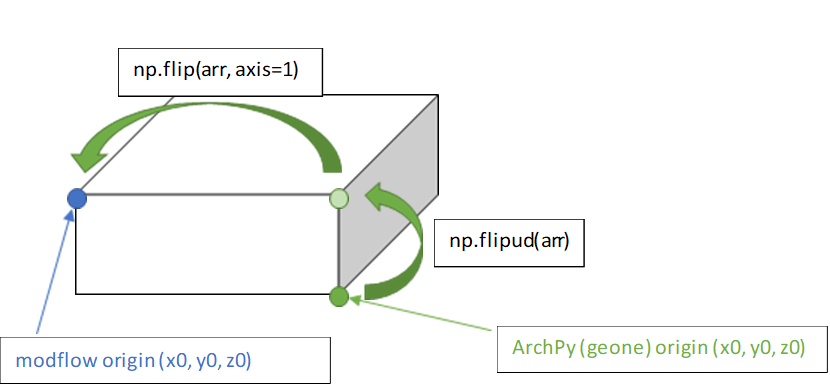
    

If you have a modflow output and want to plot it in 3D using archpy, you need to flip this array using the following command:

```python
heads = np.flipud(np.flip(heads, axis=1))
```

In [ ]:
heads = archpy_flow.get_heads()
heads[heads == 1e30] = np.nan

T1.plot_arr(np.flipud(np.flip(heads, axis=1)), "head", 2)

In [ ]:
T1.plot_prop("K", v_ex=2)

In [ ]:
plt.imshow(np.fliplr(T1.get_prop("K")[0, 0, 0, :, -1, :]), aspect=3, origin="lower", extent=[0, 200, -15, 0])

#### Particle tracking

archpy2modflow also integrates function to run particle tracking simulations. Here is an example of how to run a modpath simulation. Note that it only works with modpath 7 and particle tracking of modflow 6

In [ ]:
archpy_flow.prt_create(workspace="workspace_prt", list_p_coords=[(170.7, 99.75, -7), (170.7, 99.75, -9), (170.7, 99.75, -11)], trackdir="backward")
archpy_flow.prt_run()

In [ ]:
l_df_prt = []
for i in range(1, 4):
    l_df_prt.append(archpy_flow.prt_get_facies_path_particle(i))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for df_prt in l_df_prt:
    ax.plot(df_prt["x"], df_prt["y"], df_prt["z"])

plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, 0)
plt.axis("equal")
plt.show()

In [ ]:
ArchPy.ap_mf.plot_particle_facies_sequence(archpy_flow.T1, l_df_prt[0], plot_time=True, plot_distance=True)

#### Modpath simulations

First we need to create a modpath model and provide the path to the modpath executable. This is done using ``mp_create`` method as shown below

Initial starting point of particles can be either defined by a list of coordinates or by a list of cell indices. Here we use the first option and we provide a list to ``list_p_coord``. The tracking direction is also defined by the user. Here we use the backward tracking direction.

In [37]:
# mpexe_path = "C:/Users/emmal/switchdrive2/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
mpexe_path = "E:/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
# mpexe_path = "C:/Users/Ludovic/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
archpy_flow.mp_create(mpexe=mpexe_path, 
                      trackdir="backward", 
                      list_p_coords=[(170.7, 99.75, -7), (170.7, 99.75, -9), (170.7, 99.75, -11)])

In [ ]:
archpy_flow.mp_run(silent=False)

Pathlines and endpoints objects can be retrieve using archpy2modflow functions

In [61]:
p = archpy_flow.mp_get_pathlines_object()
e = archpy_flow.mp_get_endpoints_object()

In [40]:
l_df_mp = []
for i in range(1, 4):
    l_df_mp.append(archpy_flow.mp_get_facies_path_particle(i))

In [ ]:

path = p.get_alldata()

# 3D plot of the pathlines
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for pth in path:
    ax.plot(pth["x"], pth["y"], pth["z"])


# ax.set_aspect("equal")
plt.show()

In [ ]:
# compare the pathlines of the particles with the pathlines of the MODPATH model
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for df_mp in l_df_mp:
    ax.plot(df_mp["x"], df_mp["y"], df_mp["z"], label="MODPATH", color="blue")

for df_prt in l_df_prt:
    ax.plot(df_prt["x"], df_prt["y"], df_prt["z"], label="Particle Tracker", color="red")

plt.show()

In [ ]:
T1.plot_facies(inside_units=[C], v_ex=1, excludedVal=[])

### Layers mode

In [ ]:
archpy_flow = archpy2modflow(T1, exe_name="../../../../exe/mf6.exe")
archpy_flow.create_sim(grid_mode="layers", iu=0)
archpy_flow.set_k(k_key="K", iu=0, ifa=0, ip=0, log=True, k_average_method="anisotropic")

In [263]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [271]:
self = archpy_flow
nlay, nrow, ncol = self.T1.get_nz(), self.T1.get_ny(), self.T1.get_nx()
top = self.T1.get_surface(typ="top")[0][0, iu]
top = np.flip(top, axis=1)
botm = self.T1.get_surface(typ="bot")[0][:, iu]
botm = np.flip(botm, axis=1)
layers_names = self.T1.get_surface(typ="bot")[1]
self.layers_names = layers_names
nlay = botm.shape[0]

# define idomain (1 if thickness > 0, 0 if nan, -1 if thickness = 0)
idomain = np.ones((nlay, nrow, ncol))
thicknesses = -np.diff(np.vstack([top.reshape(-1, nrow, ncol), botm]), axis=0)
idomain[thicknesses == 0] = -1
idomain[np.isnan(thicknesses)] = 0

# adapt botm in order that each layer has a thickness > 0 
for i in range(-1, nlay-1):
    if i == -1:
        s1 = top
    else:
        s1 = botm[i]
    s2 = botm[i+1]
    mask = s1 == s2
    s1[mask] += 1e-2

In [ ]:
(top - botm[0] <= 0).any()

In [281]:
# add BC at left and right on all layers
h1 = 100
h2 = 0
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1))

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2))

chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)
    

In [ ]:
sim.write_simulation()
sim.ims.complexity = "moderate"
sim.ims.write()
sim.run_simulation()

In [284]:
heads = archpy_flow.get_heads()
heads[heads == 1e30] = np.nan

cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

In [ ]:
# plots
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
axes = ax.flatten()
from flopy.plot import PlotMapView
for ilayer in range(gwf.modelgrid.nlay):
    mapview = PlotMapView(model=gwf, layer=ilayer, ax=axes[ilayer])
    quadmesh = mapview.plot_array(heads[ilayer], cmap="Blues")
    mapview.plot_vector(qx[ilayer], qy[ilayer], color="black", istep=3, jstep=3)
    axes[ilayer].set_title("Layer {}".format(ilayer))

In [ ]:
# plot cross section
from flopy.plot import PlotCrossSection
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cross_section = PlotCrossSection(model=gwf, line={"column": 15})
cross_section.plot_array(heads, cmap="Blues", ax=ax)
cross_section.plot_vector(qx, qy, qz, color="black", normalize=True)
cross_section.plot_grid(linewidth=0.5, color="black")

In [289]:
workspace = sim.simulation_data.mfpath.get_sim_path()

In [291]:
archpy_flow.prt_create(workspace="workspace_prt", list_p_coords=[(170.7, 99.75, -7), (170.7, 99.75, -9), (170.7, 99.75, -11)], trackdir="backward")

In [ ]:
archpy_flow.prt_run()

In [ ]:
archpy_flow.prt_get_pathlines()

In [295]:

l_df_pi_prt = []
for i in range(1, 4):
    df = pd.DataFrame(archpy_flow.prt_get_facies_path_particle(i))
    l_df_pi_prt.append(df)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for df in l_df_pi_prt:
    ax.plot(df["x"], df["y"], df["z"])
    
plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, -5)
ax.set_aspect("equalxy")
plt.show()

In [ ]:
%matplotlib inline

i_particle = 1

colors_fa = []
for col in l_df_pi_prt[i_particle].columns:
    if col.split("_")[0] == "facies":
        id_fa = int(col.split("_")[-1])
        color_fa = archpy_flow.T1.get_facies_obj(ID=id_fa, type="ID").c
        colors_fa.append(color_fa)

fig, ax = plt.subplots(2, 1, figsize=(10, 3), dpi=300)
plt.subplots_adjust(hspace=0.5)
l_df_pi_prt[i_particle].set_index("time").iloc[:, -len(colors_fa):].plot(color=colors_fa, legend=False, ax=ax[0])
ax[0].set_ylabel("Proportion")
ax[0].set_xlabel("time [days]")
ax[0].set_ylim(-.1, 1.1)

l_df_pi_prt[i_particle].set_index("cum_distance").iloc[:, -len(colors_fa):].plot(color=colors_fa, legend=False, ax=ax[1])
ax[1].set_ylabel("Proportion")
ax[1].set_xlabel("Distance [m]")
ax[1].set_ylim(-.1, 1.1)

In [83]:
# modpath and pathlines
# mpexe_path = "C:/Users/emmal/switchdrive2/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
mpexe_path = "E:/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
# mpexe_path = "C:/Users/Ludovic/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
archpy_flow.mp_create(mpexe=mpexe_path, 
                      trackdir="backward", 
                      list_p_coords=[(170.7, 99.75, -7), (170.7, 99.75, -9), (170.7, 99.75, -11)])

In [84]:
# archpy_flow.mp_create([(1, 20, 120)],
#                       mpexe="E:/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe", 
#                       trackdir="backward",
#                       rowcelldivisions=3, columncelldivisions=3, layercelldivisions=3)

In [ ]:
archpy_flow.mp_run(silent=False)

In [86]:
p = archpy_flow.mp_get_pathlines_object()

In [87]:
path = p.get_alldata()

In [ ]:
path[0][["x", "y", "z"]][0]

In [ ]:
archpy_flow.mp_get_facies_path_particle(0, fac_time=1/86400)

In [90]:
df = pd.DataFrame(p.get_alldata()[1])
cells_path = np.array((((df["z"].values-T1.zg[0])//T1.sz).astype(int), 
                       ((df["y"].values-T1.yg[0])//T1.sy).astype(int), 
                       ((df["x"].values-T1.xg[0])//T1.sx).astype(int))).T

In [91]:
iu = 0
ifa = 0

time_ordered = df["time"].values.copy()
time_ordered /= 86400

# add a column to track distance traveled
df["distance"] = 0
for i in range(1, df.shape[0]):
    x0, y0, z0 = df[["x", "y", "z"]].iloc[i-1]
    x1, y1, z1 = df[["x", "y", "z"]].iloc[i]
    distance = np.sqrt((x1-x0)**2 + (y1-y0)**2 + (z1-z0)**2)
    df.loc[df.index[i], "distance"] = distance

df["cum_distance"] = df["distance"].cumsum()

dic_facies_path = {}
# retrieve lithologies along the pathlines
for fa in archpy_flow.T1.get_all_facies():
    id_fa = fa.ID
    prop_fa = archpy_flow.upscaled_facies[id_fa]

    facies_along_path = prop_fa[cells_path[:, 0], cells_path[:, 1], cells_path[:, 2]]
    dic_facies_path[fa.ID] = facies_along_path

dt = np.diff(time_ordered)

# store everything in a new dataframe
df_all = pd.DataFrame(columns=["dt", "time", "distance", "cum_distance"])
df_all["dt"] = dt
df_all["time"] = time_ordered[:-1]
df_all["distance"] = df["distance"].values[:-1]
df_all["cum_distance"] = df["cum_distance"].values[:-1]

colors_fa = []
for k, v in dic_facies_path.items():
    df_all["facies_prop_"+ str(k)] = v[:-1]
    colors_fa.append(archpy_flow.T1.get_facies_obj(ID=k, type="ID").c)
# df_all["facies"] = facies_along_path[:-1]

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 3), dpi=300)
plt.subplots_adjust(hspace=0.5)
df_all.set_index("time").iloc[:, 3:].plot(color=colors_fa, legend=False, ax=ax[0])
ax[0].set_ylabel("Proportion")
ax[0].set_xlabel("time [days]")
ax[0].set_ylim(-.1, 1.1)

df_all.set_index("cum_distance").iloc[:, 3:].plot(color=colors_fa, legend=False, ax=ax[1])
ax[1].set_ylabel("Proportion")
ax[1].set_xlabel("Distance [m]")
ax[1].set_ylim(-.1, 1.1)

In [103]:
l_df_pi_mp = []
for i in range(3):
    df = pd.DataFrame(archpy_flow.mp_get_facies_path_particle(i))
    l_df_pi_mp.append(df)

In [ ]:
# 3D plot of the pathlines
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for pth in l_df_pi_mp:
    ax.plot(pth["x"], pth["y"], pth["z"])

plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, 0)
ax.set_aspect("equal")
plt.show()

In [ ]:
%matplotlib inline
# compare pathlines from modpath and pathlines
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for pth in l_df_pi[:]:
    ax.plot(pth["x"], pth["y"], pth["z"], color="red", alpha=1)

for pth in l_df_pi_mp[:]:
    ax.plot(pth["x"], pth["y"], pth["z"], color="blue", alpha=1)

In [116]:
# create an array with k values of the layer mode
self = archpy_flow
gwf = self.get_gwf()
nrow, ncol, nlay = gwf.modelgrid.nrow, gwf.modelgrid.ncol, gwf.modelgrid.nlay

# initialize new_k and new_k33
kh = self.T1.get_prop("K")[0, 0, 0] 
new_k = np.zeros(kh.shape)
new_k33 = np.zeros(kh.shape)

layers = self.layers_names
mask_units = [self.T1.unit_mask(l).astype(bool) for l in layers]

for irow in range(nrow):
    for icol in range(ncol):
        for ilay in range(nlay):
            mask_unit = mask_units[ilay]
            new_k[:, irow, icol][mask_unit[:, irow, icol]] = np.mean(kh[:, irow, icol][mask_unit[:, irow, icol]])
            new_k33[:, irow, icol][mask_unit[:, irow, icol]] = 1 / np.mean(1 / kh[:, irow, icol][mask_unit[:, irow, icol]])

new_k[new_k == 0] = np.nan
new_k33[new_k33 == 0] = np.nan
k_lay = new_k.copy()

In [ ]:
T1.plot_arr(k_lay, v_ex=3, slicex=0.5, slicey=0.5)

### Upscaled model

In [ ]:
archpy_flow = archpy2modflow(T1, exe_name="../../../../exe/mf6.exe")
archpy_flow.create_sim(grid_mode="new_resolution", iu=0, factor_x=4, factor_y=2, factor_z=2)
archpy_flow.set_k(k_key="K", iu=0, ifa=0, ip=0, log=True,
                k_average_method="new_resolution")

In [64]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [65]:
pv.set_jupyter_backend("static")

In [ ]:
pl = pv.Plotter(shape=(1, 3), window_size=[2000, 700])
v_ex=10
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()
arr = np.log10(gwf.npf.k.array)
arr[arr==arr[0, 0, 0]] = np.nan
arr = np.flip(np.flipud(arr), axis=1)
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=gwf.dis.delr[0], sy=gwf.dis.delc[0], sz=0.15*v_ex, val=arr, nv=1,
                   varname=["Upscaled model"])
geone.imgplot3d.drawImage3D_surface(im, plotter=pl)


pl.subplot(0, 1)
arr = k_lay
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=3, sy=3, sz=0.15*v_ex, nv=1,
                    val=arr.reshape(1, *arr.shape), varname=["Layer model"])
geone.imgplot3d.drawImage3D_surface(im, plotter=pl)

pl.subplot(0, 2)
arr = T1.get_prop("K", 0, 0, 0, all_data=False)
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=3, sy=3, sz=0.15*v_ex, nv=1,
                    val=arr.reshape(1, *arr.shape), varname=["Original model"])
geone.imgplot3d.drawImage3D_surface(im, plotter=pl)

pl.show()

In [67]:
# add BC at left and right on all layers
h1 = 100
h2 = 0
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1))

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2))

chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)

In [ ]:
sim.write_simulation()
sim.ims.complexity = "moderate"
sim.ims.write()
sim.run_simulation()

In [ ]:
archpy_flow.prt_create(workspace="workspace_prt", list_p_coords=[(170.7, 99.75, -7), (170.7, 99.75, -9), (170.7, 99.75, -11)], trackdir="backward")
archpy_flow.prt_run()

In [70]:
l_df_pi_prt = []
for i in range(1, 4):
    df = pd.DataFrame(archpy_flow.prt_get_facies_path_particle(i))
    l_df_pi_prt.append(df)

In [ ]:
archpy_flow.prt_get_facies_path_particle(3)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for df in l_df_pi_prt[:3]:
    ax.plot(df["x"], df["y"], df["z"], label="Particle Tracker", alpha=.7)

In [ ]:
i_particle = 0

colors_fa = []
for col in l_df_pi_prt[i_particle].columns:
    if col.split("_")[0] == "facies":
        id_fa = int(col.split("_")[-1])
        color_fa = archpy_flow.T1.get_facies_obj(ID=id_fa, type="ID").c
        colors_fa.append(color_fa)

fig, ax = plt.subplots(2, 1, figsize=(10, 2), dpi=300)
plt.subplots_adjust(hspace=0.8)
l_df_pi_prt[i_particle].set_index("time").iloc[:, -len(colors_fa):].plot(color=colors_fa, legend=False, ax=ax[0])
ax[0].set_ylabel("Proportion")
ax[0].set_xlabel("time [days]")
ax[0].set_ylim(-.1, 1.1)

l_df_pi_prt[i_particle].set_index("cum_distance").iloc[:, -len(colors_fa):].plot(color=colors_fa, legend=False, ax=ax[1])
ax[1].set_ylabel("Proportion")
ax[1].set_xlabel("Distance [m]")
ax[1].set_ylim(-.1, 1.1)

In [ ]:
# mpexe_path = "C:/Users/Ludovic/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
mpexe_path = "E:/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
archpy_flow.mp_create(mpexe=mpexe_path, 
                      trackdir="backward", 
                      list_p_coords=[(170.7, 99.75, -7), (170.7, 99.75, -9), (170.7, 99.75, -11)])
archpy_flow.mp_run(silent=False)

In [114]:
df_pi = archpy_flow.mp_get_facies_path_particle(0)

In [119]:
l_df_pi_mp = []
for i in range(3):
    df = pd.DataFrame(archpy_flow.mp_get_facies_path_particle(i))
    l_df_pi_mp.append(df)

In [116]:
colors_fa = []
for col in df_pi.columns:
    if col.split("_")[0] == "facies":
        id_fa = int(col.split("_")[-1])
        color_fa = archpy_flow.T1.get_facies_obj(ID=id_fa, type="ID").c
        colors_fa.append(color_fa)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4), dpi=300)
plt.subplots_adjust(hspace=0.5)
df_pi.set_index("time").iloc[:, -len(colors_fa):].plot(color=colors_fa, legend=False, ax=ax[0])
ax[0].set_ylabel("Proportion")
ax[0].set_xlabel("time [days]")
ax[0].set_ylim(-.1, 1.1)

df_pi.set_index("cum_distance").iloc[:, -len(colors_fa):].plot(color=colors_fa, legend=False, ax=ax[1])
ax[1].set_ylabel("Proportion")
ax[1].set_xlabel("Distance [m]") 
ax[1].set_ylim(-.1, 1.1)

In [ ]:
p = archpy_flow.mp_get_pathlines_object()
path = p.get_alldata()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for pth in path[:]:
    ax.plot(pth["x"], pth["y"], pth["z"])

plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, 0)
plt.show()

In [ ]:
# compare the pathlines of the particles with the pathlines of the MODPATH model

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for df_mp in l_df_pi_mp:
    ax.plot(df_mp["x"], df_mp["y"], df_mp["z"], label="MODPATH", color="blue")

for df_prt in l_df_pi_prt:
    ax.plot(df_prt["x"], df_prt["y"], df_prt["z"], label="Particle Tracker", color="red")

plt.show()

how to compare pathlines using different grid mode ?

- compute distance between the two pathlines (optimal transport, frechet distance)
- difference between time and distance traveled
- compare facies encountered (but how ?)
- compare units encountered

## Comparisons

In [124]:
np.random.seed(1)
# compare pathlines between the 3 modes

n_loc = 10
particles_loc_x = np.random.uniform(100, T1.get_xg()[-1], n_loc)
particles_loc_y = np.random.uniform(0, T1.get_yg()[-1], n_loc)
particles_loc_z = np.random.uniform(-12, -7, n_loc)
particles_loc = list(zip(particles_loc_x, particles_loc_y, particles_loc_z))
particles_loc.append((170.7, 99.75, -9))
n_loc += 1

In [125]:
def add_chd(archpy_flow, h1=100, h2=0):

    # add BC at left and right on all layers
    chd_data = []

    gwf = archpy_flow.get_gwf()
    
    a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
    a[:, :, 0] = 1
    lst_chd = array2cellids(a, gwf.dis.idomain.array)
    for cellid in lst_chd:
        chd_data.append((cellid, h1))

    a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
    a[:, :, -1] = 1
    lst_chd = array2cellids(a, gwf.dis.idomain.array)
    for cellid in lst_chd:
        chd_data.append((cellid, h2))

    chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)

In [ ]:
iu = 0
ifa = 0
modflow_path = "../../../../exe/mf6.exe"

# Archpy grid mode #
archpy_flow = archpy2modflow(T1, exe_name=modflow_path)
archpy_flow.create_sim(grid_mode="archpy", iu=iu)
archpy_flow.set_k("K", iu, ifa, 0, log=True)

sim = archpy_flow.get_sim()

add_chd(archpy_flow, 100, 0)

sim.write_simulation()
sim.ims.complexity = "complex"
sim.ims.write()
sim.run_simulation()

# Particle Tracker mode #
archpy_flow.prt_create(workspace="workspace_prt", list_p_coords=particles_loc, trackdir="backward")
archpy_flow.prt_run()

l_df_pi_archpy = []
for i in range(n_loc):
    l_df_pi_archpy.append(archpy_flow.prt_get_facies_path_particle(i+1))

# Layer mode #
archpy_flow = archpy2modflow(T1, exe_name=modflow_path)
archpy_flow.create_sim(grid_mode="layers", iu=iu)
archpy_flow.set_k("K", iu, ifa, 0, log=True)

sim = archpy_flow.get_sim()

add_chd(archpy_flow, 100, 0)

sim.write_simulation()
sim.ims.complexity = "moderate"
sim.ims.write()
sim.run_simulation()

archpy_flow.prt_create(workspace="workspace_prt", list_p_coords=particles_loc, trackdir="backward")
archpy_flow.prt_run()

l_df_pi_layer = []
for i in range(n_loc):
    l_df_pi_layer.append(archpy_flow.prt_get_facies_path_particle(i+1))

# New resolution mode #
archpy_flow = archpy2modflow(T1, exe_name=modflow_path)
archpy_flow.create_sim(grid_mode="new_resolution", iu=iu, factor_x=4, factor_y=2, factor_z=2)
archpy_flow.set_k("K", iu, ifa, 0, log=True)

sim = archpy_flow.get_sim()

add_chd(archpy_flow, 100, 0)

sim.write_simulation()
sim.ims.complexity = "moderate"
sim.ims.write()
sim.run_simulation()

archpy_flow.prt_create(workspace="workspace_prt", list_p_coords=particles_loc, trackdir="backward")
archpy_flow.prt_run()

l_df_pi_new_res = []
for i in range(n_loc):
    l_df_pi_new_res.append(archpy_flow.prt_get_facies_path_particle(i+1))

In [ ]:
# iu = 0
# ifa = 0

# # mpexe_path = "C:/Users/emmal/switchdrive2/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
# mpexe_path = "E:/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
# # mpexe_path = "C:/Users/Ludovic/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
# modflow_path = "../../../../exe/mf6.exe"

# # Archpy grid mode #
# archpy_flow = archpy2modflow(T1, exe_name=modflow_path)
# archpy_flow.create_sim(grid_mode="archpy", iu=iu)
# archpy_flow.set_k("K", iu, ifa, 0, log=True)

# sim = archpy_flow.get_sim()

# add_chd(archpy_flow, 100, 0)

# sim.write_simulation()
# sim.ims.complexity = "complex"
# sim.ims.write()
# sim.run_simulation()

# archpy_flow.mp_create(mpexe=mpexe_path, 
#                       trackdir="backward", 
#                       list_p_coords=particles_loc)
# archpy_flow.mp_run(silent=False)

# l_df_pi = []
# for pi in range(n_loc):
#     df_pi = get_df_particle(archpy_flow, pi, fac_time=1/86400)
#     l_df_pi.append(df_pi)

# # Layers grid mode #
# archpy_flow = archpy2modflow(T1, exe_name=modflow_path)
# archpy_flow.create_sim(grid_mode="layers", iu=iu)
# archpy_flow.set_k("K", iu, ifa, 0, log=True)

# sim = archpy_flow.get_sim()

# add_chd(archpy_flow, 100, 0)

# sim.write_simulation()
# sim.ims.complexity = "moderate"
# sim.ims.write()
# sim.run_simulation()

# archpy_flow.mp_create(mpexe=mpexe_path,
#                         trackdir="backward",
#                         list_p_coords=particles_loc)
# archpy_flow.mp_run(silent=False)

# l_df_pi_layers = []
# for pi in range(n_loc):
#     df_pi = get_df_particle(archpy_flow, pi, fac_time=1/86400)
#     l_df_pi_layers.append(df_pi)

# # New resolution grid mode #
# archpy_flow = archpy2modflow(T1, exe_name=modflow_path)
# archpy_flow.create_sim(grid_mode="new_resolution", iu=iu, factor_x=4, factor_y=2, factor_z=2)
# archpy_flow.set_k("K", iu, ifa, 0, log=True, k_average_method="new_resolution")

# sim = archpy_flow.get_sim()

# add_chd(archpy_flow, 100, 0)

# sim.write_simulation()
# sim.ims.complexity = "moderate"
# sim.ims.write()
# sim.run_simulation()

# archpy_flow.mp_create(mpexe=mpexe_path,
#                         trackdir="backward",
#                         list_p_coords=particles_loc)
# archpy_flow.mp_run(silent=False)

# l_df_pi_new_res = []
# for pi in range(n_loc):
#     df_pi = get_df_particle(archpy_flow, pi, fac_time=1/86400)
#     l_df_pi_new_res.append(df_pi)


In [155]:
from ArchPy.ap_mf import plot_particle_facies_sequence

In [ ]:

plot_particle_facies_sequence(archpy_flow.T1, l_df_pi_archpy[8], plot_distance=True)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for df in l_df_pi_archpy:
    ax.plot(df["x"], df["y"], df["z"])
    
plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, -5)
ax.set_aspect("equalxy")
plt.show()

In [ ]:
%matplotlib tk
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

i_particle = 9
for df in [l_df_pi_archpy[i_particle]]:
    ax.plot(df["x"], df["y"], df["z"], color="k")
    ax.scatter(df["x"], df["y"], df["z"], c=np.log10(df["time"]), cmap="viridis")
    print(df["time"].max())
for df in [l_df_pi_layer[i_particle]]:
    ax.plot(df["x"], df["y"], df["z"], color="r")
    # ax.scatter(df["x"], df["y"], df["z"], c=df["time"], cmap="viridis")
    print(df["time"].max())
for df in [l_df_pi_new_res[i_particle]]:
    ax.plot(df["x"], df["y"], df["z"], color="b")
    ax.scatter(df["x"], df["y"], df["z"], c=np.log10(df["time"]), cmap="viridis")
    print(df["time"].max())
    
plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, -5)
ax.set_aspect("equalxy")
plt.show()

In [ ]:
path1 = l_df_pi_archpy[4][["x", "y", "z", "time"]]
# indicate that time column is in days and set as index
# path1.loc[:, "time"] = pd.to_timedelta(path1["time"], unit="d")

path2 = l_df_pi_layer[4][["x", "y", "z", "time"]]
# indicate that time column is in days and set as index
# path2.loc[:, "time"] = pd.to_timedelta(path2["time"], unit="d")

# from dtaidistance import dtw_ndim
# d = dtw_ndim.distance(path1.values, path2.values)

# DTW(path1.values, path2.values)

# merge the two dataframes on time
df_merge = pd.merge(path1, path2, on="time", suffixes=("_1", "_2"), how="outer").fillna(method="bfill").set_index("time")
path1 = df_merge[["x_1", "y_1", "z_1"]].fillna(method="ffill")
path2 = df_merge[["x_2", "y_2", "z_2"]].fillna(method="ffill")
path1

In [ ]:
from dtaidistance import dtw_ndim
d = dtw_ndim.distance(path1.values, path2.values)
d

In [ ]:
frechet_distance(path1.values, path2.values)

In [ ]:
hausdorff_distance(path1.values, path2.values)

In [237]:
from scipy.spatial import distance

def DTW(path1, path2):
    """
    Compute the Frechet distance between two pathlines
    """
    
    # compute the distance between each point of the two pathlines
    dist = distance.cdist(path1, path2)

    # compute frechet matrix
    MF = np.zeros(dist.shape)
    for i in range(dist.shape[0]):
        for j in range(dist.shape[1]):
            if i == 0 and j == 0:
                MF[i, j] = dist[i, j]
            elif i == 0:
                MF[i, j] = dist[i, j]
            elif j == 0:
                MF[i, j] = dist[i, j]
            else:
                MF[i, j] = dist[i, j] + min(MF[i-1, j], MF[i, j-1], MF[i-1, j-1])

    return MF[-1, -1]

def frechet_distance(path1, path2):

    # compute the distance between each point of the two pathlines
    dist = distance.cdist(path1, path2)

    # compute frechet matrix
    MF = np.zeros(dist.shape)
    for i in range(dist.shape[0]):
        for j in range(dist.shape[1]):
            if i == 0 and j == 0:
                MF[i, j] = dist[i, j]
            elif i == 0:
                MF[i, j] = max(MF[i, j-1], dist[i, j])
            elif j == 0:
                MF[i, j] = max(MF[i-1, j], dist[i, j])
            else:
                MF[i, j] = max(min(MF[i-1, j], MF[i, j-1], MF[i-1, j-1]), dist[i, j])
    
    return MF[-1, -1]

def hausdorff_distance(path1, path2):
    """
    Compute the Hausdorff distance between two pathlines
    """
    
    from scipy.spatial.distance import directed_hausdorff

    d1 = directed_hausdorff(path1, path2)
    return d1[0]

In [240]:
%matplotlib inline

In [ ]:
# write a function to compute the frechet distance between two pathlines

l_layer_frechet = []
l_new_res_frechet = []
l_layer_hausdorff = []
l_new_res_hausdorff = []
l_layer_dtw = []
l_new_res_dtw = []
for i_particle in range(n_loc):
    if i_particle in [6, 7]:
        # l_layer_frechet.append(np.nan)
        # l_layer_hausdorff.append(np.nan)
        # l_new_res_frechet.append(np.nan)
        # l_new_res_hausdorff.append(np.nan)
        # l_layer_dtw.append(np.nan)
        # l_new_res_dtw.append(np.nan)
        pass
    else:
        # compute frechet and hausdorffdistance
        path1 = l_df_pi_archpy[i_particle][["x", "y", "z"]].values
        path2 = l_df_pi_layer[i_particle][["x", "y", "z"]].values
        l_layer_frechet.append(frechet_distance(path1, path2))
        l_layer_hausdorff.append(hausdorff_distance(path1, path2))

        path2 = l_df_pi_new_res[i_particle][["x", "y", "z"]].values
        l_new_res_frechet.append(frechet_distance(path1, path2))
        l_new_res_hausdorff.append(hausdorff_distance(path1, path2))
        
        # # DTW
        path1 = l_df_pi_archpy[i_particle][["x", "y", "z", "time"]]
        # path1.loc[:, "time"] = pd.to_timedelta(path1["time"], unit="d")

        path2 = l_df_pi_layer[i_particle][["x", "y", "z", "time"]]
        # path2.loc[:, "time"] = pd.to_timedelta(path2["time"], unit="d")

        # # merge the two dataframes on time
        df_merge = pd.merge(path1, path2, on="time", suffixes=("_1", "_2"), how="outer").fillna(method="ffill").set_index("time")
        path1 = df_merge[["x_1", "y_1", "z_1"]].fillna(method="bfill")
        path2 = df_merge[["x_2", "y_2", "z_2"]].fillna(method="bfill")

        l_layer_dtw.append(DTW(path1.values, path2.values))

        path1 = l_df_pi_archpy[i_particle][["x", "y", "z", "time"]]
        # path1.loc[:, "time"] = pd.to_timedelta(path1["time"], unit="d")

        path2 = l_df_pi_new_res[i_particle][["x", "y", "z", "time"]]
        # path2.loc[:, "time"] = pd.to_timedelta(path2["time"], unit="d")

        # # merge the two dataframes on time
        df_merge = pd.merge(path1, path2, on="time", suffixes=("_1", "_2"), how="outer").fillna(method="ffill").set_index("time")
        path1 = df_merge[["x_1", "y_1", "z_1"]].fillna(method="bfill")
        path2 = df_merge[["x_2", "y_2", "z_2"]].fillna(method="bfill")
        l_new_res_dtw.append(DTW(path1.values, path2.values))


fig, ax = plt.subplots(3, 1, figsize=(10, 8))
ax[0].plot(l_layer_frechet, label="Layers mode")
ax[0].plot(l_new_res_frechet, label="New resolution mode")
ax[0].set_xlabel("Particle")
ax[0].set_ylabel("Frechet distance")
ax[0].legend()

ax[1].plot(l_layer_hausdorff, label="Layers mode")
ax[1].plot(l_new_res_hausdorff, label="New resolution mode")
ax[1].set_xlabel("Particle")
ax[1].set_ylabel("Hausdorff distance")
ax[1].legend()

ax[2].plot(l_layer_dtw, label="Layers mode")
ax[2].plot(l_new_res_dtw, label="New resolution mode")
ax[2].set_xlabel("Particle")
ax[2].set_ylabel("DTW distance")
ax[2].legend()

plt.show()

print("Frechet distance")
print("Layers mode: ", np.mean(l_layer_frechet))
print("New resolution mode: ", np.mean(l_new_res_frechet))
print("Hausdorff distance")
print("Layers mode: ", np.mean(l_layer_hausdorff))
print("New resolution mode: ", np.mean(l_new_res_hausdorff))
print("DTW distance")
print("Layers mode: ", np.mean(l_layer_dtw))
print("New resolution mode: ", np.mean(l_new_res_dtw))

In [ ]:
sum(np.array(l_new_res_frechet) < np.array(l_layer_frechet)) / len(l_new_res_frechet)

In [193]:
# retrieve lithologies along the pathlines
facies_domains = T1.get_facies(0, 0, all_data = False)
facies_along_path = facies_domains[unique_cells_ordered[:, 0], unique_cells_ordered[:, 1], unique_cells_ordered[:, 2]][::-1]

In [ ]:
%matplotlib inline
# plot cumulative distribution of the facies along the pathlines vs the time
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4)

curves = []

list_facies = [fa for fa in T1.get_all_facies()]
# orders facies by proportions
list_facies = sorted(list_facies, key=lambda x: -np.sum(facies_along_path == x.ID))
for fa in list_facies:
    curves.append(np.cumsum(facies_along_path == fa.ID) / len(facies_along_path))

prev_curve = np.zeros_like(curves[0], dtype=float)
for i, fa in enumerate(list_facies):
    curve = curves[i].astype(float) 
    curve[curve == 0] = np.nan
    ax[0].fill_between(-time_ordered, curve+prev_curve, prev_curve, alpha=0.5, color=fa.c)
    # ax[0].plot(-time_ordered, curve+prev_curve, label=fa.name, color=fa.c, marker="o", linewidth=0)
    prev_curve[~np.isnan(curve)] = curve[~np.isnan(curve)] + prev_curve[~np.isnan(curve)]

ax[0].set_xlabel("Time (s)", fontsize=12)
ax[0].set_ylabel("Cumulative proportion of facies", fontsize=12)
ax[0].set_title("cdf of facies along the pathlines")
# print time spent in each facies 

df_time = pd.DataFrame(columns=[fa.name for fa in list_facies])
# initialize the time spent in each facies
time_spent = np.zeros(len(list_facies))
for i, fa in enumerate(list_facies):
    time_spent[i] = np.sum(facies_along_path == fa.ID)
df_time.loc[0] = time_spent

for i in range(len(time_ordered)-1):
    dt = time_ordered[i] - time_ordered[i+1]
    for j, fa in enumerate(list_facies):
        if facies_along_path[i] == fa.ID:
            time_spent[j] += dt

df_time /= 86400  # convert seconds to days

color_facies = [fa.c for fa in list_facies]

df_time.plot(kind="bar", color=color_facies, legend=False, logy=False, ax=ax[1])
ax[1].set_title("Time spent in each facies (days)")
ax[1].set_ylabel("Time spent (days)", fontsize=12)
plt.grid()
plt.show()